In [1]:
import warnings; warnings.simplefilter('ignore')
import imp, os, pickle, pandas, numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from scipy.misc import imresize
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


### NOTES
- t.Subject != the subject number: the file-name subject 73 is the within-file subject 70  

In [2]:
# thank you for sending this! 
data_directory = 'data_for_tyler'
# loading all file names 
data_files = [i for i in os.listdir(data_directory) if 'xls' in i] 

In [3]:
# difficulty of each trial from README
difficulty_key = {3:'easy', 4:'medium', 5:'difficult'}
# subject names from README
name_key = {1:'IR', 73:'AN', 72:'SD'}

In [184]:
# initialize dataframe 
df = pandas.DataFrame({})

# iterate over all files 
for i_file in data_files: 
    
    # extract subject id from filename
    subject_number = int(i_file[4:-12]) 
    # convert id to name in paper
    subject_name = [name_key[subject_number] if subject_number in name_key else 'control'][0]    
    # load excel file
    xls = pandas.read_excel(os.path.join(data_directory, i_file))
    # extract oddity files with README info 
    trials = xls[(xls.Attribute1 == 'o') | (xls.Attribute1 == 'm') | (xls.Attribute1 == 'd')]

    for idx in range(len(trials)): 
 
        # select single trial
        t = trials.iloc[idx]
        if t.Attribute1 == 'o': 
            # index of next trial through last
            next_idx = min(idx+1, len(trials)-1)
            # name difficulty 
            trial_difficulty = difficulty_key[t.Attribute2]
            # check this and the next trial to determine accuracy 
            i_correct = t.correct == t['Slide1.RESP'] or t.correct == trials.iloc[next_idx]['TextDisplay51.RESP']

            # collect relevant trial-level observations
            trial_data  = pandas.Series(
                {'image1': t.facepic1, 
                 'image2': t.facepic2,
                 'image3': t.facepic3, 
                 'correct_responses': t.correct, 
                 'subject': subject_number, # t.Subject
                 'difficulty': trial_difficulty, 
                 'name': subject_name,
                 'correct': i_correct })
            
            # store trial-level data
            df = df.append(trial_data, ignore_index=True) 

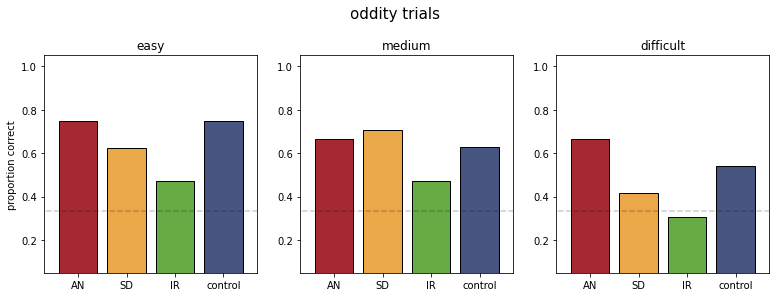

In [185]:
patient_names = ['AN', 'SD', 'IR', 'control']
# colors to match the figure 3 in paper 
colors = {'AN': '#A52931', "SD": '#EBA848', 'IR': '#67AB44', 'control':'#475681'}

plt.figure(figsize=[13, 4])
i_plot=1

for i_task in list( difficulty_key.values()  ) : 
    
    plt.subplot(1, 3, i_plot) ; i_plot+=1
    location = 0 
    for i in patient_names: 
        location += 1 
        plt.bar(location, df[(df.difficulty==i_task) * (df.name==i)].mean().correct, 
                color=colors[i], edgecolor='black')
    plt.xticks(range(1, len(patient_names)+1), patient_names)
    plt.title(i_task)
    plt.ylim(.05, 1.05)
    plt.xlim(.3, 4.7)
    plt.hlines([1/3, 1/3], xmin= 0, xmax = 5, linestyle='--', color='black', alpha=.1)
plt.suptitle('oddity trials', y=1.05, fontsize=15) 
plt.subplot(131); plt.ylabel('proportion correct'); 

In [186]:
unique_images = np.array([df.image3.unique(),
                          df.image1.unique(), 
                          df.image2.unique(), 
                          ]).flatten() 

In [187]:
image_directory = '/Users/biota/work/mtl_perception/retrospective/imhoff_2018/oddity_memory_trials'

In [189]:
each_image, missing = {}, []  

for i_image in unique_images: 
    
    img_path = os.path.join(image_directory, i_image[:-3] + 'BMP')

    if os.path.exists( img_path ) : 
        tmp_image = Image.open(img_path)
        each_image[i_image] = tmp_image.copy() 
        tmp_image.close() 
    else: 
        missing.append( i_image )

In [211]:
df = df[ np.array([i not in missing for i in df.image1]) * 
         np.array([i not in missing for i in df.image2]) * 
         np.array([i not in missing for i in df.image3]) ] 

In [212]:
if 0: 
    def load_model(path_to_model):
        """return model and session"""
        session = tf.Session()
        vgg16 = imp.load_source('vgg16', os.path.join(path_to_model, 'vgg16.py'))
        imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.vgg16(imgs, os.path.join(path_to_model, 'vgg16_weights.npz'), session)
        return vgg, session

    # set base directory all analyses are contained within
    base_directory = os.path.abspath('..')

    # set path to model
    path_to_model = os.path.join(base_directory, 'model')

    # define model
    model, session = load_model(path_to_model)

    imgs = {i: imresize(each_image[i], (224, 224, 3)) for i in each_image}

    model_responses = {}

    for i in imgs:
        print( i )
        model_responses[i] = session.run(model.conv5_1, feed_dict={model.imgs: np.expand_dims(imgs[i], 0)}).flatten()

In [215]:
correct = [] 
distance = [] 

for i_trial in range(len(df)):    

    t = df.iloc[i_trial]
    
    i_numbers = [t['image%s'%i][-7:-4] for i in [1,2,3]]
    # get ground truth 
    i_correct_response = np.argmax(i_numbers)
    # extract responses to these stimuli
    i_responses = [model_responses[t['image%s'%i] ] for i in [1,2,3]]
    # generate covariance matrix for trial
    i_covariance = np.corrcoef(i_responses)
    # identify item with lowest off diagonal mean correlation
    model_decision = i_covariance.mean(0).argmin()
    # sort covariance matrix -- so we can ignore diagonal 
    i_covariance.sort()
    # estimate mean off diagonal 
    i_nearest = i_covariance[:,:-1].mean(1)
    # determine if farthest is the oddity
    correct.append(model_decision == i_correct_response)
    # store distance between oddity and typicals
    distance.append(i_nearest[ model_decision ])

In [245]:
df['model_performance'] = correct 
df['model_distance'] = distance 

In [250]:
df.groupby(['difficulty','name']).mean()

correct  correct_responses    subject  model_performance  \
difficulty name                                                                 
difficult  AN       0.652174           2.043478  73.000000               True   
           IR       0.314286           1.942857   1.000000               True   
           SD       0.391304           2.043478  72.000000               True   
           control  0.550586           1.944622  46.577210               True   
easy       AN       0.761905           2.047619  73.000000               True   
           IR       0.454545           1.969697   1.000000               True   
           SD       0.619048           2.047619  72.000000               True   
           control  0.744633           1.970621  46.589831               True   
medium     AN       0.666667           1.833333  73.000000               True   
           IR       0.472222           2.000000   1.000000               True   
           SD       0.708333           1.833333  72.000000               True   
           control  0.630435           1.997930  46.571429               True   

                    model_distance  
difficulty name                     
difficult  AN             0.962257  
           IR             0.961015  
           SD             0.962257  
           control        0.961016  
easy       AN             0.937615  
           IR             0.938143  
           SD             0.937615  
           control        0.938225  
medium     AN             0.957578  
           IR             0.954485  
           SD             0.957578  
           control        0.954530

Text(0, 0.5, 'Human Performance')

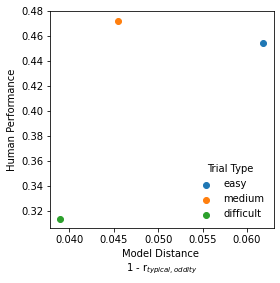

In [246]:
plt.figure(figsize=[4,4])
prc_data = df[df.name=='IR']
Y = [] 
X = [] 
for i_task in ['easy', 'medium', 'difficult']: 
    
    plt.scatter( y = prc_data[prc_data.difficulty==i_task]['correct'].mean(), 
                 x = 1-prc_data[prc_data.difficulty==i_task]['model_distance'].mean(), 
                label=i_task) 
    Y.append( prc_data[prc_data.difficulty==i_task]['correct'].mean() )
    X.append( 1-prc_data[prc_data.difficulty==i_task]['model_distance'].mean() )
    
plt.legend(loc=4, title='Trial Type', framealpha=0 ) 
plt.xlabel('Model Distance \n1 - r$_{typical, oddity}$')
plt.ylabel('Human Performance')

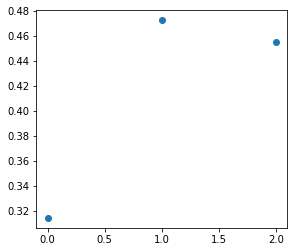

In [244]:
plt.figure(figsize=[4.5,4])
plt.scatter(x= np.array(X).argsort()[-1::-1], 
            y= np.array(Y)[np.array(X).argsort()])

In [242]:
df.to_csv('inhoff_nondiagnostic_data.csv')

In [113]:
#     plt.figure(figsize=[12, 4])
#     i_reps = [] 

#     for i in [1,2,3]: 
#         plt.subplot(1,3,i)
#         plt.title('%s\n%s'%('image%s'%i, t['image%s'%i]) )
#         plt.imshow(imgs[t['image%s'%i]])
#         i_reps.append( model_responses[t['image%s'%i]] ) 
#         plt.axis('off')

#     plt.suptitle('%s --- correct response: %s || %d-%d'%(t.difficulty, t.correct, iiii, i_nearest.argmin()), y=1.05)

#     t['image%s'%i][-7:-4]
#     plt.subplot(144)
#     plt.imshow(np.corrcoef(i_reps))
#     plt.title( (t.correct, 
#                 i_nearest.argmin(),
#                 np.corrcoef( [model_responses[ t['image%s'%i]] for i in [1,2,3]] ).mean(0).argmin()))


(3030, 8)

In [ ]:
# generate covariance
i_covariance = np.corrcoef(i_response[np.array([0,1,condition]), :])
# sort covariance matrix
i_covariance.sort()
# extract nearest neighbor
i_nearest = i_covariance[:,-2]
# determine if farthest is the oddity
correct = i_nearest.argmin() == len(i_nearest)-1
# store
model_accuracy[markers[condition]].append(correct)

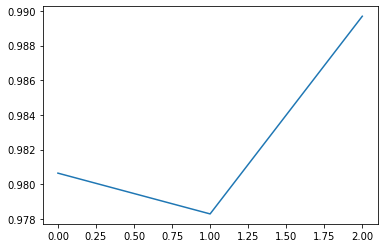

In [237]:

plt.plot( np.mean(np.corrcoef(i_reps), 0) ) 


In [206]:
cov.mean(0)

array([0.98078958, 0.97508223, 0.98793434])

In [57]:
#              't.correct': t.correct, 
#              'RESP': t['Slide1.RESP'], 
#              'TextDisplay51.RESP': t['TextDisplay51.RESP'],
#              'trial_number': t.Block, 
#              'run': run_number, 
#    run_number = int(i_file[2])

In [79]:
[df.iloc[i]['image%d'%(i+1)] for i in range(3)] 

['edfam_m337-327_082.bmp', 'ed_f73-74_053.bmp', 'ed_m98-100_097.bmp']

In [82]:
'edfam_m337-327_082.bmp' in unique_images

True

In [83]:
for i in range(5):
    
    print( [df.iloc[i]['image%d'%(i+1)] in unique_images for i in range(3)] )

[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]


In [21]:
for i in list( each_image )[0:4]: 
    
    i_response = session.run(model.conv5_1, feed_dict={model.imgs: imgs})

edfam_m337-327_082.BMP
ed_f73-74_082.BMP
ed_m98-100_030.BMP
ded464-461_087.BMP


In [ ]:
imgs = [imresize(imgs[i], (224, 224, 3)) for i in range(len(imgs))]
i_response = session.run(model.conv5_1, feed_dict={model.imgs: imgs})

In [759]:

# flatten model responses to trial images
i_response = np.reshape(i_response, (len(imgs), -1))

# determine model accuracy for 'near' and 'far' conditions
for condition in [2, 3]:
    # generate covariance
    i_covariance = np.corrcoef(i_response[np.array([0,1,condition]), :])
    # sort covariance matrix
    i_covariance.sort()
    # extract nearest neighbor
    i_nearest = i_covariance[:,-2]
    # determine if farthest is the oddity
    correct = i_nearest.argmin() == len(i_nearest)-1
    # store
    model_accuracy[markers[condition]].append(correct)

0.1716101694915254

In [ ]:


from PIL import Image
from scipy.misc import imresize
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from PIL import Image

def load_model(path_to_model):
    """return model and session"""
    session = tf.Session()
    vgg16 = imp.load_source('vgg16', os.path.join(path_to_model, 'vgg16.py'))
    imgs = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.vgg16(imgs, os.path.join(path_to_model, 'vgg16_weights.npz'), session)
    return vgg, session

def model_performance(model, session, image_path):
    """returns model performance on experiment"""
    
    # all images in stimulus directory
    images = np.sort( [i for i in os.listdir(image_path) if 'BMP' in i] )
    # all unique trials
    trial_names = np.unique([i[0:-8] for i in images])
    # trial/condition markers
    markers = ['030', '053', '082', '097']
    # initialize data types
    model_accuracy = {'082':[], '097':[], 'name':trial_names, 'markers':markers}

    for i_trial in trial_names:

        # all images in trial
        i_files = [i for i in images if i_trial in i and i[-7:-4] in markers]

        # only
        if len(i_files) == len( markers ):

            for i_face in range(len(i_files)):
                imgs = np.array([np.array(Image.open(os.path.join(image_path, i))) for i in i_files])
                imgs = [imresize(imgs[i], (224, 224, 3)) for i in range(len(imgs))]
                i_response = session.run(model.conv5_1, feed_dict={model.imgs: imgs})

            # flatten model responses to trial images
            i_response = np.reshape(i_response, (len(imgs), -1))

            # determine model accuracy for 'near' and 'far' conditions
            for condition in [2, 3]:
                # generate covariance
                i_covariance = np.corrcoef(i_response[np.array([0,1,condition]), :])
                # sort covariance matrix
                i_covariance.sort()
                # extract nearest neighbor
                i_nearest = i_covariance[:,-2]
                # determine if farthest is the oddity
                correct = i_nearest.argmin() == len(i_nearest)-1
                # store
                model_accuracy[markers[condition]].append(correct)
    
    # determine average accuracy
    model_performance = {i: np.mean(model_accuracy[i]) for i in [ '082', '097']}
    # save
    pandas.DataFrame({'accuracy' : list(model_performance.values()), 
                      'condition': list(model_performance)}).to_csv('model_performance.csv') 
    
    return model_performance
